### Oxford Pet 데이터 세트를 Tensorflow Object Detection API를 이용하여 학습 및 Object Detection 수행

### tensorflow object detection 설치하기
* tensorflow object detection github를 복사. git clone https://github.com/tensorflow/models.git

* tensorflow object detection API은 models/research/object_detection 내에 주요 API가 있지만 models/research의 다른 패키지도 사용

* models/research 에 setup.py 를 수행하기 전에 미리 protocol buffer 구동을 위한 proto compiler 설정과 protocol buffer 형태의 파일을 python 형태로 변환하는 작업 필요. 

* protoc 실행 시 command not found가 나오면 아래를 실행하여 install

    PROTOC_ZIP=protoc-3.7.1-linux-x86_64.zip   
    curl -OL https://github.com/protocolbuffers/protobuf/releases/download/v3.7.1/$PROTOC_ZIP  
    
    sudo unzip -o $PROTOC_ZIP -d /usr/local bin/protoc

    sudo unzip -o $PROTOC_ZIP -d /usr/local 'include/*'

    rm -f $PROTOC_ZIP
* models/research/ 디렉토리에서 아래 명령어를 실행하여 모든 proto 타입 파일이 .py 로 변경 수행 후 확인  
    protoc object_detection/protos/*.proto --python_out=.
    
* 이후에 models/research 에서 setup.py를 실행. setup.py는 object_detection 디렉토리에 있는 모듈만 셋업. 
    cd models/research
    python setup.py install
    
* Object Detection API는 models/research/object_detection 뿐만 아니라  models/research의 타 디렉토리에 있는 모듈도 참조함. 이를 위해 models/research 디렉토리를 Path로 설정하고 일부 패키지는 Local file기반으로 import 해야 함. 

    sys.path.append(..../models/research)
    
* object_detection/builders/model_builder_test.py 를 수행하여 정상적으로 셋업이 되었는지 확인.


#### 학습을 위한 디렉토리 생성하고 Pretrained 모델을 다운로드 받기
* wget http://download.tensorflow.org/models/object_detection/ssd_inception_v2_coco_2018_01_28.tar.gz

#### Oxford Pet Class name 매핑 파일 pbtxt 다운로드 받기 
* wget https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/pet_label_map.pbtxt

#### TF_RECORD 데이터 세트 만들기

In [ ]:
#export TRAIN_DIR=~/DLCV/Detection/tensor_api/train_pet
#export DATA_DIR=~/DLCV/data/ox_pet_tensor
#export TENSOR_OBJ_DIR=~/DLCV/Detection/tensor_api/model/research/object_detection
#export PYTHONPATH=$PYTHONPATH:~/DLCV/Detection/tensor_api/models/research:~/DLCV/Detection/tensor_api/models/research/object_detection
#python $TENSOR_OBJ_DIR/datatoolcreate_pet_tf_record.py --label_map_path=$TRAIN_DIR/annotations/pet_label_map.pbtxt --data_dir=$DATA_DIR --output_dir=$TRAIN_DIR/annotations


#### Oxford Pet을 학습하기 위한 config 파일 다운로드 받기
* wget https://github.com/tensorflow/models/blob/master/research/object_detection/samples/configs/ssd_inception_v2_pets.config
* 다운로드 후 pretrained model checkpoint,  tfrecord 데이터 세트, 기타 환경 변수 재 설정. 

#### Oxford Pet 데이터 학습 수행. 
* python train.py --logtostderr --train_dir=training/ --pipeline_config_path=training/ssd_inception_v2_coco.config

#### 학습이 완료 된 후 학습 모델을 Inference 모델로 변환 

In [ ]:
# python export_inference_graph.py --input_type image_tensor --pipeline_config_path=config/ssd_inception_v2_pets.config \
# --trained_checkpoint_prefix=training/model.ckpt-5000 --output_directory=training

#### 변환된 frozen graph 파일을 이용하여 Object Detection 수행

In [ ]:
import os
from pathlib import Path

HOME_DIR = str(Path.home())

DATA_DIR = os.path.join(HOME_DIR, 'DLCV/data/ox_pet')
ANNO_DIR = os.path.join(DATA_DIR, 'annotations')
IMAGE_DIR = os.path.join(DATA_DIR,  'images')

print(os.listdir(IMAGE_DIR))

In [ ]:
# tensorflow는 Class id를 1 부터 부여함에 유의 
labels_to_names = {1: 'Abyssinian', 2: 'Bengal', 3: 'Birman', 4: 'Bombay', 5: 'British_Shorthair', 6: 'Egyptian_Mau', 7: 'Maine_Coon',
 8: 'Persian', 9: 'Ragdoll', 10: 'Russian_Blue', 11: 'Siamese', 12: 'Sphynx', 13: 'american_bulldog', 14: 'american_pit_bull_terrier',
 15: 'basset_hound', 16: 'beagle', 17: 'boxer', 18: 'chihuahua', 19: 'english_cocker_spaniel', 20: 'english_setter', 21: 'german_shorthaired',
 22: 'great_pyrenees', 23: 'havanese', 24: 'japanese_chin', 25: 'keeshond', 26: 'leonberger', 27: 'miniature_pinscher', 28: 'newfoundland',
 29: 'pomeranian', 30: 'pug', 31: 'saint_bernard', 32: 'samoyed', 33: 'scottish_terrier', 34: 'shiba_inu', 35: 'staffordshire_bull_terrier',
 36: 'wheaten_terrier', 37: 'yorkshire_terrier'}

In [ ]:
import tensorflow as tf
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def get_tensor_detected_image(sess, img_array, use_copied_array):
    
    rows = img_array.shape[0]
    cols = img_array.shape[1]
    if use_copied_array:
        draw_img = img_array.copy()
    else:
        draw_img = img_array
    
    inp = img_array[:, :, [2, 1, 0]]  # BGR2RGB
    
    start = time.time()
    # Object Detection 수행. 
    out = sess.run([sess.graph.get_tensor_by_name('num_detections:0'),
                    sess.graph.get_tensor_by_name('detection_scores:0'),
                    sess.graph.get_tensor_by_name('detection_boxes:0'),
                    sess.graph.get_tensor_by_name('detection_classes:0')],
                   feed_dict={'image_tensor:0': inp.reshape(1, inp.shape[0], inp.shape[1], 3)})
    
    green_color=(0, 255, 0)
    red_color=(0, 0, 255)
    
    # Bounding Box 시각화 
    # Detect된 Object 별로 bounding box 시각화 
    num_detections = int(out[0][0])
    for i in range(num_detections):
        # class id와 object class score, bounding box정보를 추출
        classId = int(out[3][0][i])
        score = float(out[1][0][i])
        bbox = [float(v) for v in out[2][0][i]]
        if score > 0.4:
            left = bbox[1] * cols
            top = bbox[0] * rows
            right = bbox[3] * cols
            bottom = bbox[2] * rows
            # cv2의 rectangle(), putText()로 bounding box의 클래스명 시각화 
            cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), green_color, thickness=2)
            caption = "{}: {:.4f}".format(labels_to_names[classId], score)
            cv2.putText(draw_img, caption, (int(left), int(top + 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)
    
    print('Detection 수행시간:',round(time.time() - start, 3),"초")
    return draw_img

In [ ]:
#inference graph를 읽음. .
with tf.gfile.FastGFile('./train_pet/training/frozen_inference_graph.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    
with tf.Session() as sess:
    # Session 시작하고 inference graph 모델 로딩 
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')
    
    # 입력 이미지 생성, Object Detection된 image 반환, 반환된 image의 BGR을 RGB로 변경 
    for image_file in ['Russian_Blue_29.jpg', 'yorkshire_terrier_176.jpg', 'german_shorthaired_127.jpg' ]:
        img = cv2.imread(os.path.join(IMAGE_DIR, image_file))
        draw_img = get_tensor_detected_image(sess, img, True)

        img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(8, 8))
        plt.imshow(img_rgb)

#### 데이터 세트를 TFRecord로 변환하기

In [ ]:
import hashlib
import io
import logging
import os
import random
import re

import contextlib2
from lxml import etree
import numpy as np
import PIL.Image
import tensorflow as tf

from object_detection.dataset_tools import tf_record_creation_util
from object_detection.utils import dataset_util
from object_detection.utils import label_map_util

#### 기준 디렉토리 재 설정.

In [ ]:
from  pathlib import Path

HOME_DIR = str(Path.home())

DATA_DIR = os.path.join(HOME_DIR, 'DLCV/data/ox_pet')
ANNO_DIR = os.path.join(DATA_DIR, 'annotations')
IMAGE_DIR = os.path.join(DATA_DIR,  'images')
# pets 데이터세트를 학습을 위한 기본 directory설정. 
TRAIN_DIR = os.path.join(HOME_DIR, 'DLCV/Detection/tensor_api/train_pet')

#### 전체 파일, train 파일, valid 파일 추출.

In [ ]:
examples_list = []

for xml_file in os.listdir(ANNO_DIR):
    index = xml_file.rfind('.xml')
    if index > - 1:
        xml_file = xml_file[:xml_file.rfind('.xml')]
        examples_list.append(xml_file)

random.seed(42)
random.shuffle(examples_list)

num_examples = len(examples_list)
num_train = int(0.9 * num_examples)
train_examples = examples_list[:num_train]
val_examples = examples_list[num_train:]

print('example file count:', len(examples_list), 'train file count:',len(train_examples), \
      'val file count count:', len(val_examples))

#### 개별 xml 파일을 입력 받아서 tf Example로 변환

In [ ]:
def get_class_name_from_filename(file_name):
    file_breed = file_name[0:file_name.rfind('_')]
    return file_breed

def dict_to_tf_example(data, label_map_dict, image_subdirectory,
                       ignore_difficult_instances=False):
  
    img_path = os.path.join(image_subdirectory, data['filename'])
    with tf.gfile.GFile(img_path, 'rb') as fid:
        encoded_jpg = fid.read()
    
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = PIL.Image.open(encoded_jpg_io)
    if image.format != 'JPEG':
        raise ValueError('Image format not JPEG')
    
    key = hashlib.sha256(encoded_jpg).hexdigest()
    width = int(data['size']['width'])
    height = int(data['size']['height'])

    xmins = []
    ymins = []
    xmaxs = []
    ymaxs = []
    classes = []
    classes_text = []
    truncated = []
    poses = []
    difficult_obj = []
    masks = []
    # xml
    if 'object' in data:
        for obj in data['object']:
            difficult = bool(int(obj['difficult']))
            if ignore_difficult_instances and difficult:
                continue
            difficult_obj.append(int(difficult))

            xmin = float(obj['bndbox']['xmin'])
            xmax = float(obj['bndbox']['xmax'])
            ymin = float(obj['bndbox']['ymin'])
            ymax = float(obj['bndbox']['ymax'])
            
            xmins.append(xmin / width)
            ymins.append(ymin / height)
            xmaxs.append(xmax / width)
            ymaxs.append(ymax / height)
            class_name = get_class_name_from_filename(data['filename'])
            classes_text.append(class_name.encode('utf8'))
            classes.append(label_map_dict[class_name])
            truncated.append(int(obj['truncated']))
            poses.append(obj['pose'].encode('utf8'))
  
    feature_dict = {
      'image/height': dataset_util.int64_feature(height),
      'image/width': dataset_util.int64_feature(width),
      'image/filename': dataset_util.bytes_feature(
          data['filename'].encode('utf8')),
      'image/source_id': dataset_util.bytes_feature(
          data['filename'].encode('utf8')),
      'image/key/sha256': dataset_util.bytes_feature(key.encode('utf8')),
      'image/encoded': dataset_util.bytes_feature(encoded_jpg),
      'image/format': dataset_util.bytes_feature('jpeg'.encode('utf8')),
      'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
      'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
      'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
      'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
      'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
      'image/object/class/label': dataset_util.int64_list_feature(classes),
      'image/object/difficult': dataset_util.int64_list_feature(difficult_obj),
      'image/object/truncated': dataset_util.int64_list_feature(truncated),
      'image/object/view': dataset_util.bytes_list_feature(poses),
    }
  
    example = tf.train.Example(features=tf.train.Features(feature=feature_dict))
    return example

#### output filename과 annotations, images 디렉토리등을 입력받아 TFRecord를 생성하는 함수 생성. 

In [ ]:
def create_tf_record(output_filename, num_shards, label_map_dict, annotations_dir,
                     image_dir, examples):
 
    with contextlib2.ExitStack() as tf_record_close_stack:
        output_tfrecords = tf_record_creation_util.open_sharded_output_tfrecords(
            tf_record_close_stack, output_filename, num_shards)
        for idx, example in enumerate(examples):
            if idx % 100 == 0:
                print('On image {} of {}'.format(idx, len(examples)))
            xml_path = os.path.join(annotations_dir, example + '.xml')

            if not os.path.exists(xml_path):
                logging.warning('Could not find %s, ignoring example.', xml_path)
                continue
            with tf.gfile.GFile(xml_path, 'r') as fid:
                xml_str = fid.read()
            xml = etree.fromstring(xml_str)
            data = dataset_util.recursive_parse_xml_to_dict(xml)['annotation']

            try:
                tf_example = dict_to_tf_example(data, label_map_dict, image_dir)
                if tf_example:
                    shard_idx = idx % num_shards
                    output_tfrecords[shard_idx].write(tf_example.SerializeToString())
            except ValueError:
                print('Invalid example: %s, ignoring.', xml_path)


#### train용, validation용 TFRecord 생성

In [ ]:
from object_detection.utils import label_map_util

label_map_dict = label_map_util.get_label_map_dict(os.path.join(TRAIN_DIR, 'annotations/pet_label_map.pbtxt'))
train_output_path = os.path.join(TRAIN_DIR, 'annotations/pet_train_new.record')
val_output_path = os.path.join(TRAIN_DIR, 'annotations/pet_val_new.record')


create_tf_record(train_output_path,1, label_map_dict, ANNO_DIR, IMAGE_DIR, train_examples)
create_tf_record(val_output_path, 1, label_map_dict, ANNO_DIR, IMAGE_DIR, val_examples)

#### 학습 수행

In [ ]:
#python train.py --logtostderr --train_dir=training/ --pipeline_config_path=config/pets_new.config

In [ ]:
#### 학습된 모델을 이용하여 Inferece 모델 생성. 

In [ ]:
# python export_inference_graph.py --input_type image_tensor --pipeline_config_path=config/pets_new.config \
# --trained_checkpoint_prefix=training/model.ckpt-15000 --output_directory=training

In [18]:
# tensorflow는 Class id를 1 부터 부여함에 유의 
labels_to_names = {1: 'Abyssinian', 2: 'Bengal', 3: 'Birman', 4: 'Bombay', 5: 'British_Shorthair', 6: 'Egyptian_Mau', 7: 'Maine_Coon',
 8: 'Persian', 9: 'Ragdoll', 10: 'Russian_Blue', 11: 'Siamese', 12: 'Sphynx', 13: 'american_bulldog', 14: 'american_pit_bull_terrier',
 15: 'basset_hound', 16: 'beagle', 17: 'boxer', 18: 'chihuahua', 19: 'english_cocker_spaniel', 20: 'english_setter', 21: 'german_shorthaired',
 22: 'great_pyrenees', 23: 'havanese', 24: 'japanese_chin', 25: 'keeshond', 26: 'leonberger', 27: 'miniature_pinscher', 28: 'newfoundland',
 29: 'pomeranian', 30: 'pug', 31: 'saint_bernard', 32: 'samoyed', 33: 'scottish_terrier', 34: 'shiba_inu', 35: 'staffordshire_bull_terrier',
 36: 'wheaten_terrier', 37: 'yorkshire_terrier'}

In [19]:
import tensorflow as tf
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def get_tensor_detected_image(sess, img_array, use_copied_array):
    
    rows = img_array.shape[0]
    cols = img_array.shape[1]
    if use_copied_array:
        draw_img = img_array.copy()
    else:
        draw_img = img_array
    
    inp = img_array[:, :, [2, 1, 0]]  # BGR2RGB
    
    start = time.time()
    # Object Detection 수행. 
    out = sess.run([sess.graph.get_tensor_by_name('num_detections:0'),
                    sess.graph.get_tensor_by_name('detection_scores:0'),
                    sess.graph.get_tensor_by_name('detection_boxes:0'),
                    sess.graph.get_tensor_by_name('detection_classes:0')],
                   feed_dict={'image_tensor:0': inp.reshape(1, inp.shape[0], inp.shape[1], 3)})
    
    green_color=(0, 255, 0)
    red_color=(0, 0, 255)
    
    # Bounding Box 시각화 
    # Detect된 Object 별로 bounding box 시각화 
    num_detections = int(out[0][0])
    for i in range(num_detections):
        # class id와 object class score, bounding box정보를 추출
        classId = int(out[3][0][i])
        score = float(out[1][0][i])
        bbox = [float(v) for v in out[2][0][i]]
        if score > 0.4:
            left = bbox[1] * cols
            top = bbox[0] * rows
            right = bbox[3] * cols
            bottom = bbox[2] * rows
            # cv2의 rectangle(), putText()로 bounding box의 클래스명 시각화 
            cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), green_color, thickness=2)
            caption = "{}: {:.4f}".format(labels_to_names[classId], score)
            cv2.putText(draw_img, caption, (int(left), int(top + 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)
    
    print('Detection 수행시간:',round(time.time() - start, 3),"초")
    return draw_img

Detection 수행시간: 4.992 초
Detection 수행시간: 0.036 초
Detection 수행시간: 0.034 초


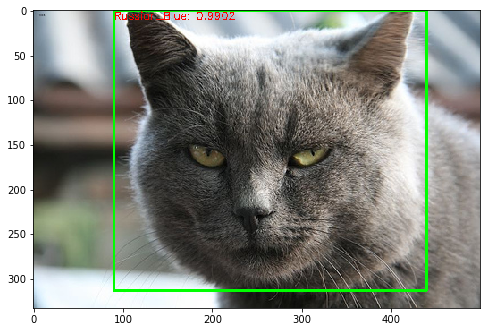

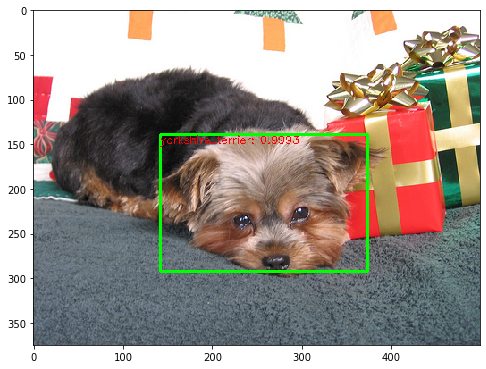

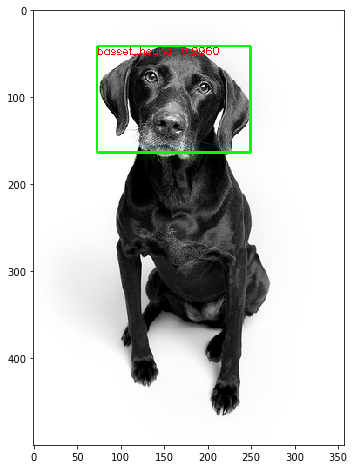

In [20]:
import os
#inference graph를 읽음. .
with tf.gfile.FastGFile('./train_pet/training/frozen_inference_graph.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    
with tf.Session() as sess:
    # Session 시작하고 inference graph 모델 로딩 
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')
    
    # 입력 이미지 생성, Object Detection된 image 반환, 반환된 image의 BGR을 RGB로 변경 
    for image_file in ['Russian_Blue_29.jpg', 'yorkshire_terrier_176.jpg', 'german_shorthaired_127.jpg' ]:
        img = cv2.imread(os.path.join(IMAGE_DIR, image_file))
        draw_img = get_tensor_detected_image(sess, img, True)

        img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(8, 8))
        plt.imshow(img_rgb)

#### OpenCV로 Object Detection 수행
* tensorflow용 config파일을 opencv 용 Config 파일로 변경 필요. 
* frozen_inference_graph.pb는 그대로 사용

In [ ]:
# wget https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/tf_text_graph_common.py
# wget https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/tf_text_graph_ssd.py
# python tf_text_graph_ssd.py --input training/frozen_inference_graph.pb --config config/pets_new.config --output config/graph.pbtxt

In [21]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

cv_net = cv2.dnn.readNetFromTensorflow('./train_pet/training/frozen_inference_graph.pb', 
                                     './train_pet/config/graph.pbtxt')

In [ ]:
def get_detected_img(cv_net, img_array, score_threshold, use_copied_array=True, is_print=True):
    
    rows = img_array.shape[0]
    cols = img_array.shape[1]
    
    draw_img = None
    if use_copied_array:
        draw_img = img_array.copy()
        #draw_img = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
    else:
        draw_img = img_array
    
    cv_net.setInput(cv2.dnn.blobFromImage(img_array, size=(300, 300), swapRB=True, crop=False))
    
    start = time.time()
    cv_out = cv_net.forward()
    
    green_color=(0, 255, 0)
    red_color=(0, 0, 255)

    # detected 된 object들을 iteration 하면서 정보 추출
    for detection in cv_out[0,0,:,:]:
        score = float(detection[2])
        class_id = int(detection[1])
        # detected된 object들의 score가 0.3 이상만 추출
        if score > score_threshold:
            # detected된 object들은 image 크기가 (300, 300)으로 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
            left = detection[3] * cols
            top = detection[4] * rows
            right = detection[5] * cols
            bottom = detection[6] * rows
            # labels_to_names 딕셔너리로 class_id값을 클래스명으로 변경. opencv에서는 class_id + 1로 매핑해야함.
            caption = "{}: {:.4f}".format(labels_to_names[class_id], score)

            #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
            cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
            cv2.putText(draw_img, caption, (int(left), int(top + 15)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, red_color, 2)
    if is_print:
        print('Detection 수행시간:',round(time.time() - start, 2),"초")

    return draw_img

Detection 수행시간: 0.22 초
Detection 수행시간: 0.17 초
Detection 수행시간: 0.17 초


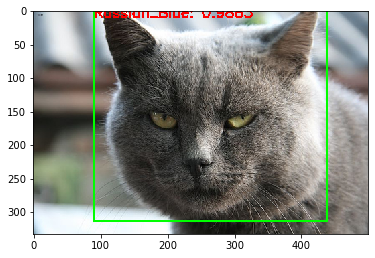

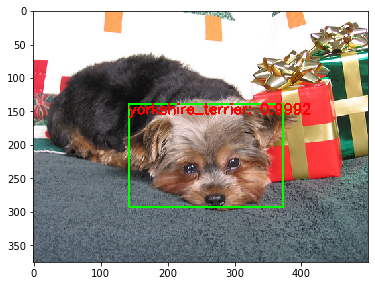

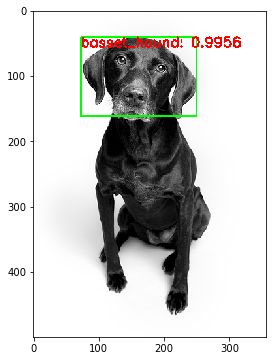

In [22]:
# tensorflow inference 모델 로딩
cv_net = cv2.dnn.readNetFromTensorflow('./train_pet/training/frozen_inference_graph.pb', 
                                     './train_pet/config/graph.pbtxt')
for image_file in ['Russian_Blue_29.jpg', 'yorkshire_terrier_176.jpg', 'german_shorthaired_127.jpg' ]:
    img = cv2.imread(os.path.join(IMAGE_DIR, image_file))
    # Object Detetion 수행 후 시각화 
    draw_img = get_detected_img(cv_net, img, score_threshold=0.4, use_copied_array=True, is_print=True)
    img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb)